In [1]:
import os
import requests
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
from langchain_core.prompts import PromptTemplate



c:\Users\prabh\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
LINKEDIN_ACCESS_TOKEN = os.getenv("LINKEDIN_ACCESS_TOKEN")
OWNER = "urn:li:person:5ko67kWFyU"

#Testing HuggingFace_Token

In [3]:
prompt = PromptTemplate(
    template="""
      You are a helpful assistant.
      

      Question: {question}
    """,
    input_variables = ['question']
)

question= "What is the capital of France?"
final_prompt = prompt.invoke({"question": question}).to_string()
print(final_prompt)


      You are a helpful assistant.


      Question: What is the capital of France?
    


In [4]:

client = InferenceClient()
llm="meta-llama/Llama-3.1-8B-Instruct"
completion = client.chat.completions.create(
    model=llm,
    messages=[
        {"role": "user", "content": final_prompt}
    ]
)

print(completion.choices[0].message.content)

The capital of France is... Paris!


Agent Implementation

In [5]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

Define Agent State Variables

In [ ]:
# define state
class JD_State(TypedDict):

    JD_Description: str
    JD: str
    linkedin_posted: bool
    linkedin_post_urn: str | None

Define Functions Needed

Define Nodes

In [ ]:
def generate_JD(state: JD_State) -> JD_State:
    JD_Description=state["JD_Description"]
    
    prompt = PromptTemplate(
    template="""
      You are a helpful assistant who can create a Job description based on the given details.
      

      Requirements: {JD_Description}
    """,
    input_variables = ['JD_Description']
    )

    
    final_prompt = prompt.invoke({"JD_Description": JD_Description}).to_string()
    
    client = InferenceClient()
    llm="meta-llama/Llama-3.1-8B-Instruct"
    completion = client.chat.completions.create(
        model=llm,
        messages=[
            {"role": "user", "content": final_prompt}
        ]
    )

    state["JD"]=completion.choices[0].message.content
    

    return state

In [ ]:
def post_jd_to_linkedin(state: JD_State) -> JD_State:
    
    load_dotenv()

    LINKEDIN_ACCESS_TOKEN = os.getenv("LINKEDIN_ACCESS_TOKEN")
    OWNER = "urn:li:person:5ko67kWFyU"
    
    # Prevent duplicate posting
    if state.get("linkedin_posted"):
        print("⚠️ JD already posted to LinkedIn. Skipping.")
        return state

    jd_text = state.get("JD")
    if not jd_text:
        raise ValueError("JD is empty. Cannot post.")

    url = "https://api.linkedin.com/v2/ugcPosts"

    headers = {
        "Authorization": f"Bearer {LINKEDIN_ACCESS_TOKEN}",
        "X-Restli-Protocol-Version": "2.0.0",
        "Content-Type": "application/json"
    }

    post_data = {
        "author": OWNER,
        "lifecycleState": "PUBLISHED",
        "specificContent": {
            "com.linkedin.ugc.ShareContent": {
                "shareCommentary": {
                    "text": jd_text
                },
                "shareMediaCategory": "NONE"
            }
        },
        "visibility": {
            "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"
        }
    }

    response = requests.post(url, headers=headers, json=post_data)

    # ❌ Failure → do NOT mark as posted
    if response.status_code not in (200, 201):
        raise RuntimeError(
            f"LinkedIn post failed: {response.status_code} - {response.text}"
        )

    response_data = response.json()

    # ✅ LinkedIn returns the post URN
    post_urn = response_data.get("id")

    if not post_urn:
        raise RuntimeError("Post created but no URN returned by LinkedIn")

    print("✅ JD successfully posted to LinkedIn")
    print("🔗 Post URN:", post_urn)

    # ✅ Update state = VERIFIED
    state["linkedin_posted"] = True
    state["linkedin_post_urn"] = post_urn

    return state

Define your Agentic Workflow

In [ ]:
# define your graph
graph = StateGraph(JD_State)

# add nodes to your graph
graph.add_node('generate_JD', generate_JD)
graph.add_node('post_jd_to_linkedin', post_jd_to_linkedin)


# add edges to your graph
graph.add_edge(START, 'generate_JD')
graph.add_edge('generate_JD', 'post_jd_to_linkedin')
graph.add_edge('post_jd_to_linkedin', END)


# compile the graph
workflow = graph.compile()

In [10]:
# execute the graph
intial_state = {'JD_Description':"I need a candidate who has 5+ yeras of experience in AI/ML"}

final_state = workflow.invoke(intial_state)

print(final_state)

✅ JD successfully posted to LinkedIn
🔗 Post URN: urn:li:share:7405556051678400512
{'JD_Description': 'I need a candidate who has 5+ yeras of experience in AI/ML', 'JD': "Here's a job description based on the requirements you provided:\n\n**Job Title:** Senior AI/ML Engineer\n\n**Job Summary:**\n\nWe are seeking an experienced Senior AI/ML Engineer with 5+ years of experience in designing, developing, and deploying artificial intelligence and machine learning solutions. The ideal candidate will have a strong background in AI/ML concepts, algorithms, and techniques, and the ability to apply them to real-world problems.\n\n**Key Responsibilities:**\n\n* Design and develop advanced AI/ML models to solve business problems using a variety of techniques such as supervised and unsupervised learning, deep learning, and natural language processing.\n* Collaborate with cross-functional teams to identify business opportunities and translate them into AI/ML solutions.\n* Develop and deploy AI/ML mo

Visuvalize your workflow

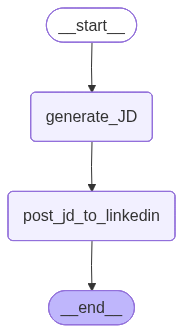

In [11]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())